# Hyperbolic discount function: commodity x condition analysis

This represents the first part of our core analysis. Namely, evaluating how log discount rates change for participants going from control to fasting conditions.

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import dabest

For docs on `dabest` package, see here https://acclab.github.io/DABEST-python-docs/index.html

## Import + process data

In [2]:
discount_func = 'Hyperbolic'
target_param = 'logk'

data_long = pd.read_csv('parameter_estimation_Hyperbolic.csv')
data_long.head()

,id,commodity,condition,model,log_loss,AUC,WAIC,roc_auc,logk
0,JL,food,C,Hyperbolic,0.148035,0.987753,13.465510,0.985102,-7.094075
1,BJ,money,C,Hyperbolic,0.291234,0.977743,24.237698,0.954691,-6.483138
2,PF,food,C,Hyperbolic,0.323278,0.914542,26.134721,0.941127,-5.048673
3,LS,money,C,Hyperbolic,0.372082,0.929108,29.070501,0.901632,-5.256610
4,DN,money,C,Hyperbolic,NaN,0.999028,1.967226,NaN,-9.643421


Convert data to wide form.

In [3]:
def long_to_wide(df, target_param):
    '''Convert long-form data to wide-form data'''
    # pivot long to wide
    df = df.set_index('id')
    df = df.pivot_table(index='id', columns=['commodity', 'condition'], values=target_param)
    # collapse column multi-index 
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    # set index to a column
    df = df.reset_index()
    return df

In [4]:
df = long_to_wide(data_long, target_param)
df.head()

,id,food C,food F,money C,money F,music C,music F
0,AB,-6.389568,-4.197637,-8.677896,-8.266407,-6.644464,-8.215289
1,AD,-3.256754,-0.028903,-5.493562,-2.888132,-4.262082,-1.614297
2,AF,-0.600203,2.379454,-2.348280,3.063776,-1.622655,-2.363139
3,AH,-3.048369,-4.264172,-3.623680,-5.878647,-3.118204,-3.556555
4,AK,-3.671881,-1.564002,-2.894231,-2.935217,-4.295574,-3.443771


Save

In [5]:
df.to_csv(f'data_wide_Hyperbolic_logk.csv', index=False)

## Calculate some derived measures
Descriptive statistics of the $\log(k)$ values

In [6]:
descriptive = df.describe()
descriptive

,food C,food F,money C,money F,music C,music F
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,-3.954534,-0.924607,-4.725219,-3.584905,-3.895352,-3.004955
std,2.366442,2.835958,2.233556,2.777490,2.166518,2.586679
min,-8.993225,-8.947500,-9.643421,-9.660717,-9.674386,-9.678076
25%,-5.564785,-2.005401,-6.504561,-5.105759,-5.061636,-3.704413
50%,-3.554092,-1.101009,-4.503234,-3.694046,-3.682267,-2.514098
75%,-2.275104,0.448193,-2.881057,-2.123396,-2.448182,-1.652283
max,1.443381,5.804997,-1.098988,6.492852,1.958837,5.771243


Calculate median half life

In [7]:
k = np.exp(descriptive.loc['50%',:])
half_life = 1. / k
hl = pd.DataFrame(half_life)
hl.rename(columns={'50%':'half_life'}, inplace=True)
hl['comm_cond'] = hl.index
hl = hl.round(1)
hl.to_csv('half_life_hyperbolic.csv', index=False)
hl

,half_life,comm_cond
food C,35.0,food C
food F,3.0,food F
money C,90.3,money C
money F,40.2,money F
music C,39.7,music C
music F,12.4,music F


Calculate the spillover effect.

In [8]:
food_change = df['food F'] - df['food C']
money_change = df['money F'] - df['money C']
music_change = df['music F'] - df['music C']

spillover_effect = np.mean([np.median(money_change/food_change),
                            np.median(music_change/food_change)])
spillover_effect = pd.DataFrame({'spillover_effect': [spillover_effect*100]})
spillover_effect = spillover_effect.round(1)
spillover_effect.to_csv('spillover_effect_logk.csv', index=False)
spillover_effect

,spillover_effect
0,24.8


## Use `dabest` package for our paired comparisons

In [9]:
test = dabest.load(df, idx=(("food C", "food F"), 
                            ("money C", "money F"),
                            ("music C", "music F")),
                   paired=True, 
                   id_col="id",
                   random_seed=12345)

## Paired mean differences

In [10]:
print(test.mean_diff)

DABEST v0.2.1
             
Good evening!
The current time is Wed May  1 22:36:08 2019.

The paired mean difference between food C and food F is 3.03 [95%CI 2.04, 4.1].
The two-sided p-value of the Wilcoxon test is 4.54e-08.

The paired mean difference between money C and money F is 1.14 [95%CI 0.308, 2.32].
The two-sided p-value of the Wilcoxon test is 5.35e-05.

The paired mean difference between music C and music F is 0.89 [95%CI 0.037, 1.86].
The two-sided p-value of the Wilcoxon test is 0.00147.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


In [11]:
test.mean_diff.statistical_tests

,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,food C,food F,mean difference,True,3.029927,95,2.039136,4.103957,4.536492e-08,71.0,1.312694e-08,-6.808697
1,money C,money F,mean difference,True,1.140314,95,0.307571,2.321327,5.347465e-05,219.0,1.314369e-03,-3.408589
2,music C,music F,mean difference,True,0.890398,95,0.037017,1.861890,1.468916e-03,308.0,1.360610e-03,-3.396884


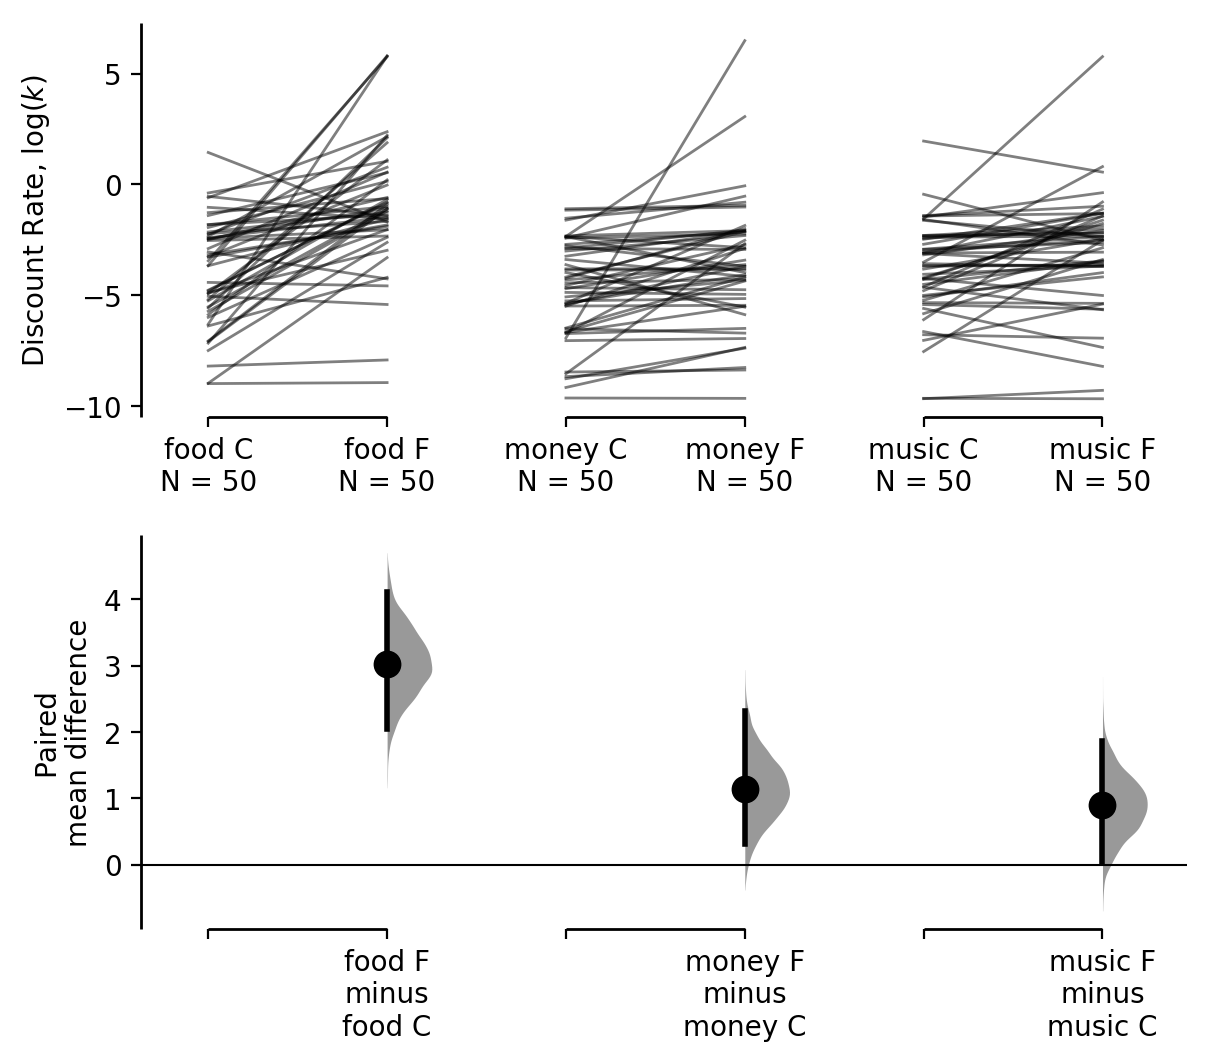

In [15]:
# plotting
model_plot = test.mean_diff.plot(swarm_label=r'Discount Rate, $\log(k)$')
plt.savefig(f'../figs/model_{discount_func}_logk.pdf', bbox_inches='tight')

## Effect size, Cohen's D
Produce the same plot but looking at the differences in terms of effect size (Cohen's D) rather than paired mean differences.

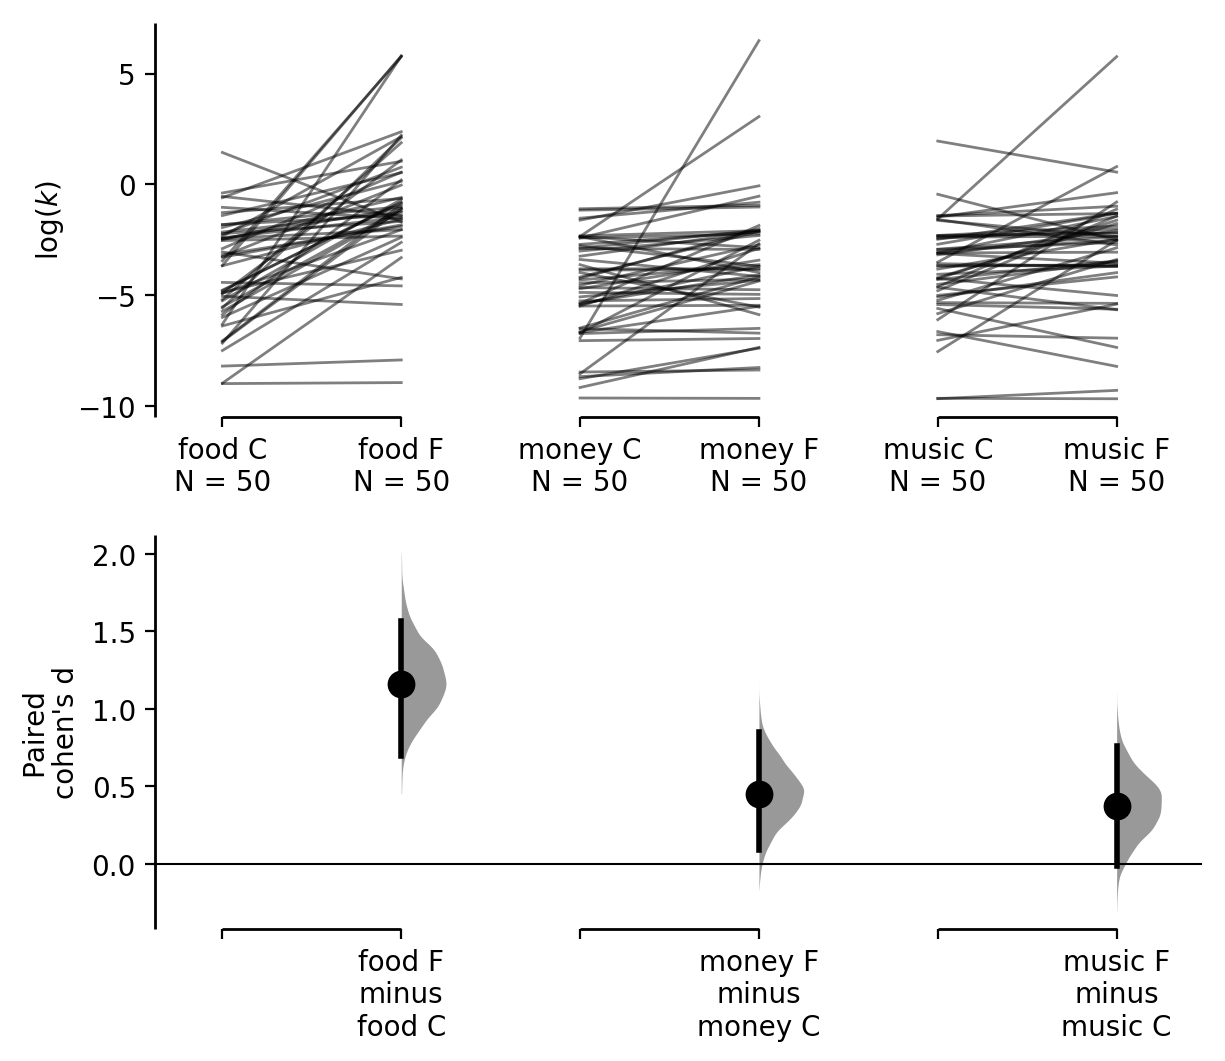

In [16]:
test.cohens_d.plot(swarm_label=r'$\log(k)$');
plt.savefig(f'../figs/model_{discount_func}_logk_effect_size.pdf', bbox_inches='tight')

In [14]:
test.cohens_d.statistical_tests

,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,food C,food F,Cohen's d,True,1.160104,95,0.694728,1.568635,4.536492e-08,71.0,1.312694e-08,-6.808697
1,money C,money F,Cohen's d,True,0.452462,95,0.091052,0.849003,5.347465e-05,219.0,1.314369e-03,-3.408589
2,music C,music F,Cohen's d,True,0.373197,95,-0.013234,0.756937,1.468916e-03,308.0,1.360610e-03,-3.396884
